# Risk assessment for heavy snowfall & blizzards

## Risk assessment methodology

The method involves visually representing the susceptible population exposed to intense snowfall and blizzards. This can be achieved by overlaying indicators for heavy snowfall and blizzards with population data. The objective is to understand the present probability of severe snowfall and blizzards, pinpointing the regions most impacted within Europe. Additionally, we seek to investigate how climate change may modify this exposure over time.


### Blizzard  

A blizzard is a severe storm condition defined by low temperature, sustained wind or frequent wind gust and considerable precipitating or blowing snow. For blizzard conditions we propose the use of following impact indicator:

**Blizzard days** = Tmean  ≤ 0 °C, Rs (snow amount) ≥ 10 cm and Wg (wind gust) ≥ 17 m/s ( Vajda et al., 2014). 

This impact indicator was defined taking into account the exposure of critical infrastructure, i.e., roads, rails, power lines, telecommunication to the hazard and is based on an extensive literature review, media reports, surveys conducted with European CI operators and case studies. 


### Heavy Snow 

Heavy snowfall may cause many disruptions and impacts in various sectors; however, the impacts and consequences of this hazard depend on the affected sector, infrastructure and also preparedness of society that varies over Europe.  For example, already a few centimeters of snow can disrupt road traffic, but doesn’t normally cause any harm to energy infrastructure. Many weather services have three warning levels based on the severity of expected impacts, which are typically different for different sectors of infrastructure. There is a large variation in the national warning criteria or thresholds.

Similarly to blizzard, the impact indicators for heavy snowfall were defined taking into account the exposure of critical infrastructure, i.e., roads, rails, power lines, telecommunication to the hazard and is based on an extensive literature review, media reports, surveys conducted with European CI operators and case studies. The qualitative description of the two-level thresholds are:

**1st threshold ( > 6 cm):** Some adverse impacts are expected, their severity depends on the resilience of the system, transportation is mainly affected.

**2nd threshold ( > 25 cm):**  The weather phenomena are so severe that is likely that adverse impact will occur, CI system is seriously impacted.

This code calculates the Annual probability (%) of a blizzard and heavy snowfall days during the specified period and a region of interest.


**The annual probability**

The annual probability is determined by dividing the count of events surpassing predefined thresholds within a year by the total number of days in that year. The result is then multiplied by 100 to express the probability as a percentage

P =    ((variable > threshold) / days in year ) X 100


## Preparation work

### Select area of interest
Before accessing the data, we will define the area of interest. Prior to commencing this workflow, you should have already prepared by downloading the heavy snowfall and blizzards hazard map to your local directory (using the SNOW hazard workflow for heavy snowfall and blizzards or by using your own data). Please specify the name of the area for the snow hazard maps below.

In [1]:
areaname = 'Europe'

### Load libraries

:::{admonition} Find more info about the libraries used in this workflow here
:class: hint dropdown

- [warnings](https://docs.python.org/3/library/warnings.html) - To control the Python warning message 
- [os](https://docs.python.org/3/library/os.html) - To create directories and work with files
- [pooch](https://www.fatiando.org/pooch/latest/index.html) - To download and unzip the data
- [numpy](https://numpy.org) - Numerical computing tools  
- [xarray](https://docs.xarray.dev/en/stable/) - To process the NetCDF data and prepare it for further calculation
- [xesmf](https://xesmf.readthedocs.io/en/stable/) - Universal regridder for geospatial data
- [rioxarray](https://corteva.github.io/rioxarray/stable/) - Rasterio xarray extension - to make it easier to use GeoTIFF data with xarray
- [rasterio](https://rasterio.readthedocs.io/en/stable/) - To access and explore geospatial raster data in GeoTIFF format
- [matplotlib](https://matplotlib.org/) - To plot the maps 
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) - To plot the maps
:::

In [2]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

import os

import pooch
import numpy as np
np.warnings = warnings
import xarray as xr
import xesmf as xe
import rioxarray as rxr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

/Users/poladesu/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


##  Create the directory structure 

In order for this workflow to work even if you download and use just this notebook, we need to have the directory structure for accessing and storing data. If you have already executed the hazard assessment workflow for snow, you would already have created the workflow folder 'SNOW_hazard' where the hazard data is stored. We create an additional folder for the risk workflow, called 'SNOW_risk'.


In [3]:
workflow_folder = 'SNOW_hazard'
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)

general_data_folder = os.path.join(workflow_folder, 'general_data')

# Check if the general data folder exists, if not, create it
if not os.path.exists(general_data_folder):
    os.makedirs(general_data_folder)

In [4]:
data_dir = os.path.join(workflow_folder,f'data_{areaname}')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

plot_dir = os.path.join(workflow_folder,f'plots_{areaname}')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

## Download and explore the data

### Hazard data - intense snowfall and blizzards maps

As default option, we use the intense snowfall and blizzards maps from the [ERA5 single level dataset](https://cds-beta.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=overview) and [CORDEX single level dataset](https://cds-beta.climate.copernicus.eu/datasets/projections-cordex-domains-single-levels?tab=overview), that were downloaded using the hazard assessment workflow for snow and blizzards.
Below we load the maps and visualize them to check the contents.

### Define parameters for the EURO-CORDEX data
These parameters have to be the same as in the Hazard workflow.


In [5]:
Hist_start_year    = '1991'
Hist_end_year      = '1995'
Hist_experiment_in = 'historical'

RCP_start_year     = '2046'
RCP_end_year       = '2050'

experiment_names  =['rcp_2_6','rcp_4_5','rcp_8_5']
experiment_names1 =['rcp26','rcp45','rcp85']
experiment_choice   = 0

RCP_experiment_in  = experiment_names[experiment_choice]
RCP_experiment_in1  = experiment_names1[experiment_choice]

ensemble_member_in = 'r1i1p1'



#List of model names for download and extraction
gcm_names=['ncc_noresm1_m','mpi_m_mpi_esm_lr','cnrm_cerfacs_cnrm_cm5','cnrm_cerfacs_cnrm_cm5',
          'ncc_noresm1_m']
rcm_names=['geric_rem020150','smhi_rca4','knmi_racm022e','cnrm_aladin63','smhi_rca4']

gcm_extr_list=['NCC-NorESM1-M','MPI-M-MPI-ESM-LR','CNRM-CERFACS-CNRM-CM5',
              'CNRM-CERFACS-CNRM-CM5','NCC-NorESM1-M']
rcm_extr_list=['GERICS-REMO2015','SMHI-RCA4','KNMI-RACMO22E','CNRM-ALADIN63','SMHI-RCA4']

#Select the global and regional climate model combination you want to use
model_choice   = 1

gcm_model_in   = gcm_names[model_choice]
rcm_model_in   = rcm_names[model_choice]

gcm_model_Name = gcm_extr_list[model_choice]
rcm_model_Name = rcm_extr_list[model_choice]


print(RCP_experiment_in)
print(gcm_model_Name)
print(rcm_model_Name)

rcp_2_6
MPI-M-MPI-ESM-LR
SMHI-RCA4


In [6]:
# ERA5
BdayCount_anaProb_mean_path = os.path.join(data_dir,f'BdayCount_AnaProb_mean_ERA5_{Hist_start_year}_{Hist_end_year}.nc')
BdayCount_anaProb_mean_ERA = xr.open_dataset(BdayCount_anaProb_mean_path,decode_coords='all')

snow6Prob_annual_mean_path = os.path.join(data_dir,f'Snow6Prob_annual_mean_ERA5_{Hist_start_year}_{Hist_end_year}.nc')
snow6Prob_annual_mean_ERA = xr.open_dataset(snow6Prob_annual_mean_path,decode_coords='all')

snow25Prob_annual_mean_path = os.path.join(data_dir,f'Snow25Prob_annual_mean_ERA5_{Hist_start_year}_{Hist_end_year}.nc')
snow25Prob_annual_mean_ERA = xr.open_dataset(snow25Prob_annual_mean_path,decode_coords='all')

In [7]:
# CORDEX Hist
BdayCount_anaProb_mean_path = os.path.join(data_dir,f'BdayCount_AnaProb_mean_{gcm_model_Name}_{rcm_model_Name}_{Hist_experiment_in}_{ensemble_member_in}_{Hist_start_year}_{Hist_end_year}.nc')
BdayCount_anaProb_mean_hist = xr.open_dataset(BdayCount_anaProb_mean_path,decode_coords='all')

snow6Prob_annual_mean_path = os.path.join(data_dir,f'Snow6Prob_annual_mean_{gcm_model_Name}_{rcm_model_Name}_{Hist_experiment_in}_{ensemble_member_in}_{Hist_start_year}_{Hist_end_year}.nc')
snow6Prob_annual_mean_hist = xr.open_dataset(snow6Prob_annual_mean_path,decode_coords='all')

snow25Prob_annual_mean_path = os.path.join(data_dir,f'Snow25Prob_annual_mean_{gcm_model_Name}_{rcm_model_Name}_{Hist_experiment_in}_{ensemble_member_in}_{Hist_start_year}_{Hist_end_year}.nc')
snow25Prob_annual_mean_hist = xr.open_dataset(snow25Prob_annual_mean_path,decode_coords='all')

In [9]:
# CORDEX Future
BdayCount_anaProb_mean_path = os.path.join(data_dir,f'BdayCount_AnaProb_mean_{gcm_model_Name}_{rcm_model_Name}_{RCP_experiment_in1}_{ensemble_member_in}_{RCP_start_year}_{RCP_end_year}.nc')
BdayCount_anaProb_mean_fur = xr.open_dataset(BdayCount_anaProb_mean_path,decode_coords='all')

snow6Prob_annual_mean_path = os.path.join(data_dir,f'Snow6Prob_annual_mean_{gcm_model_Name}_{rcm_model_Name}_{RCP_experiment_in1}_{ensemble_member_in}_{RCP_start_year}_{RCP_end_year}.nc')
snow6Prob_annual_mean_fur = xr.open_dataset(snow6Prob_annual_mean_path,decode_coords='all')

snow25Prob_annual_mean_path = os.path.join(data_dir,f'Snow25Prob_annual_mean_{gcm_model_Name}_{rcm_model_Name}_{RCP_experiment_in1}_{ensemble_member_in}_{RCP_start_year}_{RCP_end_year}.nc')
snow25Prob_annual_mean_fur = xr.open_dataset(snow25Prob_annual_mean_path,decode_coords='all')

In [10]:
BdayCount_anaProb_mean_change = BdayCount_anaProb_mean_fur - BdayCount_anaProb_mean_hist
BdayCount_anaProb_mean_change = BdayCount_anaProb_mean_change.where(BdayCount_anaProb_mean_hist > 1, other=0)

snow6Prob_annual_mean_change = snow6Prob_annual_mean_fur - snow6Prob_annual_mean_hist
snow6Prob_annual_mean_change = snow6Prob_annual_mean_change.where(snow6Prob_annual_mean_hist > 1, other=0)

snow25Prob_annual_mean_change = snow25Prob_annual_mean_fur - snow25Prob_annual_mean_hist
snow25Prob_annual_mean_change = snow25Prob_annual_mean_change.where(snow25Prob_annual_mean_hist > 1, other=0)

BdayCount_anaProb_mean_change = BdayCount_anaProb_mean_change.drop_vars(['rotated_pole','height'])
snow6Prob_annual_mean_change  = snow6Prob_annual_mean_change.drop_vars(['rotated_pole','height'])
snow25Prob_annual_mean_change = snow25Prob_annual_mean_change.drop_vars(['rotated_pole','height'])

#### Ploting functions



In [11]:
def plot_overlay_map(var1, var2, V1_p_levels, V2_p_levels, V1_cmap, V2_cmap, Tit1,
                     V1_cb_tit, V2_cb_tit,fileout,min_lon, max_lon, min_lat, max_lat):
    """Plot overlay plot variable with rotated grid and standard grid"""
    np.warnings.filterwarnings('ignore')
    # Create a figure and subplot
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(0, 35))

    # Plot Var1 data
    p_var1 = var1.plot.contourf(ax=ax, levels=V1_p_levels, cmap=V1_cmap,
                                                                 transform=ccrs.PlateCarree(), alpha=0.5, add_colorbar=False)
    # Plot Var2 data
    p_var2 = var2.plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), levels=V2_p_levels,
                                                                        cmap=V2_cmap, alpha=0.5, add_colorbar=False)
    # Set the extent of the plot to the specified latitude and longitude box
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

    # Add coastlines and features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
    ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='aliceblue')

    # Add latitude and longitude labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False

    # Set title
    plt.title(Tit1, loc="left", fontsize=16)

    # Add colorbars
    cbar_var2 = fig.colorbar(p_var2, ax=ax, location='left', shrink=0.5,  pad=0.05)
    cbar_var2.set_label(V1_cb_tit)
    cbar_var1 = fig.colorbar(p_var1, ax=ax, location='right', shrink=0.5,  pad=0.05)
    cbar_var1.set_label(V2_cb_tit)
    plt.subplots_adjust(right=0.8, left=0.2)

    # Save the figure
    fig.savefig(fileout)

In [12]:
def plot_map_ERA5(var1, V1_p_levels, V1_cmap,Tit1, V1_cb_tit,fileout):
    """Plot ERA5 data"""
    np.warnings.filterwarnings('ignore')
    # Create a figure and subplot
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(0, 35))

    # Plot Var1 data
    p_var1 = var1.plot.contourf(ax=ax, levels=V1_p_levels, cmap=V1_cmap,
                                                                 transform=ccrs.PlateCarree(), add_colorbar=False)

    # Add coastlines and features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
    ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='aliceblue')

    # Add latitude and longitude labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False

    # Set title
    plt.title(Tit1, loc="left", fontsize=16)

    # Add colorbars
    cbar_var1 = fig.colorbar(p_var1, ax=ax, location='right', shrink=0.5,  pad=0.05)
    cbar_var1.set_label(V1_cb_tit)
    #plt.subplots_adjust(right=0.8, left=0.2)

    # Save the figure
    fig.savefig(fileout)

In [13]:
def plot_map_CORDEX(var1, V1_p_levels, V1_cmap, Tit1, V1_cb_tit,fileout):
    """Plot CORDEX data"""
    np.warnings.filterwarnings('ignore')
    # Create a figure and subplot
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(0, 35))

    # Plot Var1 data
    p_var1 = var1.plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), levels=V1_p_levels,
                                                                        cmap=V1_cmap, add_colorbar=False)
    # Add coastlines and features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
    ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='aliceblue')

    # Add latitude and longitude labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False

    # Set title
    plt.title(Tit1, loc="left", fontsize=16)

    # Add colorbars
    cbar_var1 = fig.colorbar(p_var1, ax=ax, location='right', shrink=0.5,  pad=0.05)
    cbar_var1.set_label(V1_cb_tit)

    # Save the figure
    fig.savefig(fileout)

#### Plot change in annual probability


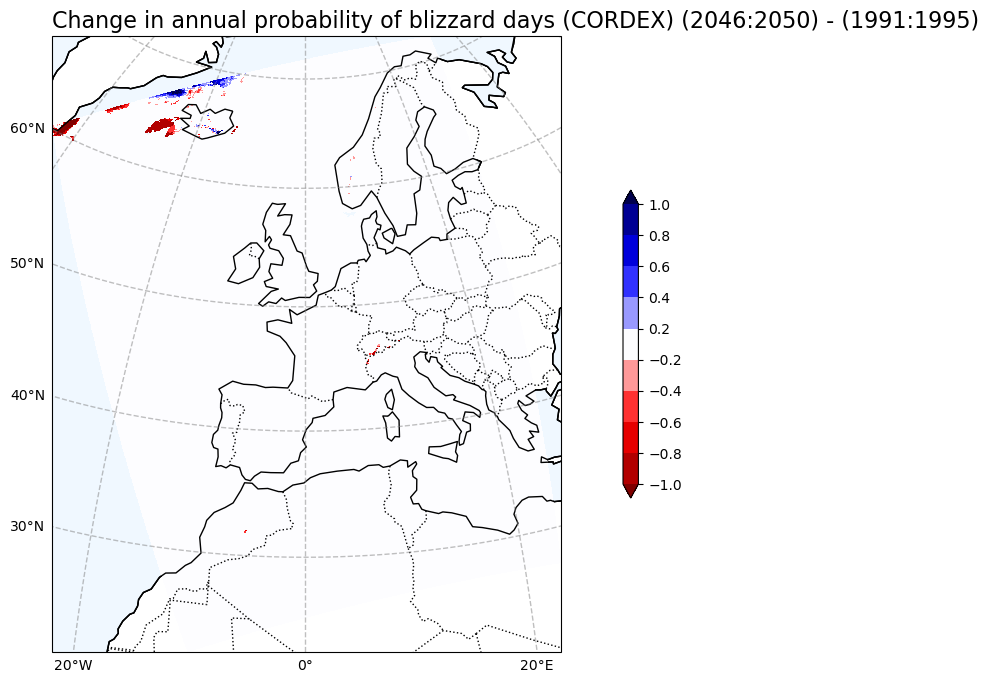

In [14]:
# Plot change in Annual probability of blizzard days
var1 = BdayCount_anaProb_mean_change.blizzard_days
V1_p_levels = [-1, -0.8, -0.6, -0.4, -0.2, 0.2, 0.4, 0.6, 0.8, 1]
V1_cmap = 'seismic_r'

Tit1 = f'Change in annual probability of blizzard days (CORDEX) ({RCP_start_year}:{RCP_end_year}) - ({Hist_start_year}:{Hist_end_year})'
V1_cb_tit = ' '
fileout = os.path.join(plot_dir, f'Chan_Ann_prob_blizzard_days_CORDEX_{gcm_model_Name}_{rcm_model_Name}_{RCP_experiment_in1}_{ensemble_member_in}_{RCP_start_year}_{RCP_end_year}.png')

plot_map_CORDEX(var1, V1_p_levels, V1_cmap, Tit1, V1_cb_tit,fileout)

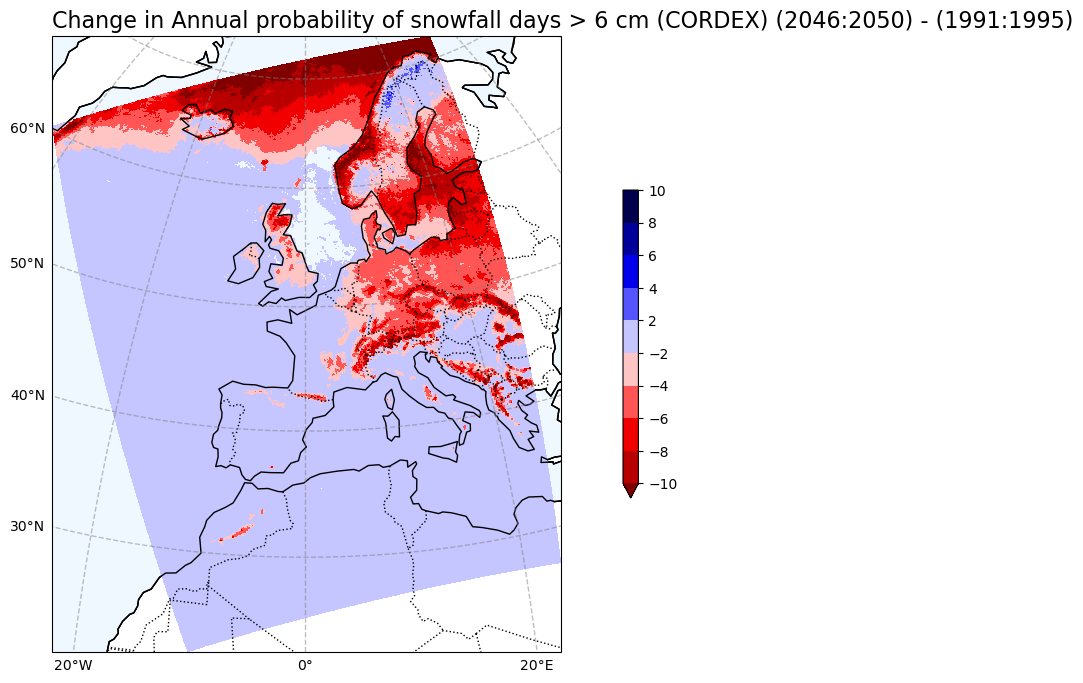

In [15]:
# Plot change in Annual probability of snowfall exceeding 6 cm
var1 = snow6Prob_annual_mean_change.snow_days

V1_p_levels = [-10, -8, -6, -4, -2, 2, 4, 6, 8, 10]
V1_cmap = 'seismic_r'

Tit1 = f'Change in Annual probability of snowfall days > 6 cm (CORDEX) ({RCP_start_year}:{RCP_end_year}) - ({Hist_start_year}:{Hist_end_year})'
V1_cb_tit = ' '
fileout = os.path.join(plot_dir, f'Chan_Ann_prob_snow_days_6_CORDEX_{gcm_model_Name}_{rcm_model_Name}_{RCP_experiment_in1}_{ensemble_member_in}_{RCP_start_year}_{RCP_end_year}.png')

plot_map_CORDEX(var1, V1_p_levels, V1_cmap, Tit1, V1_cb_tit,fileout)

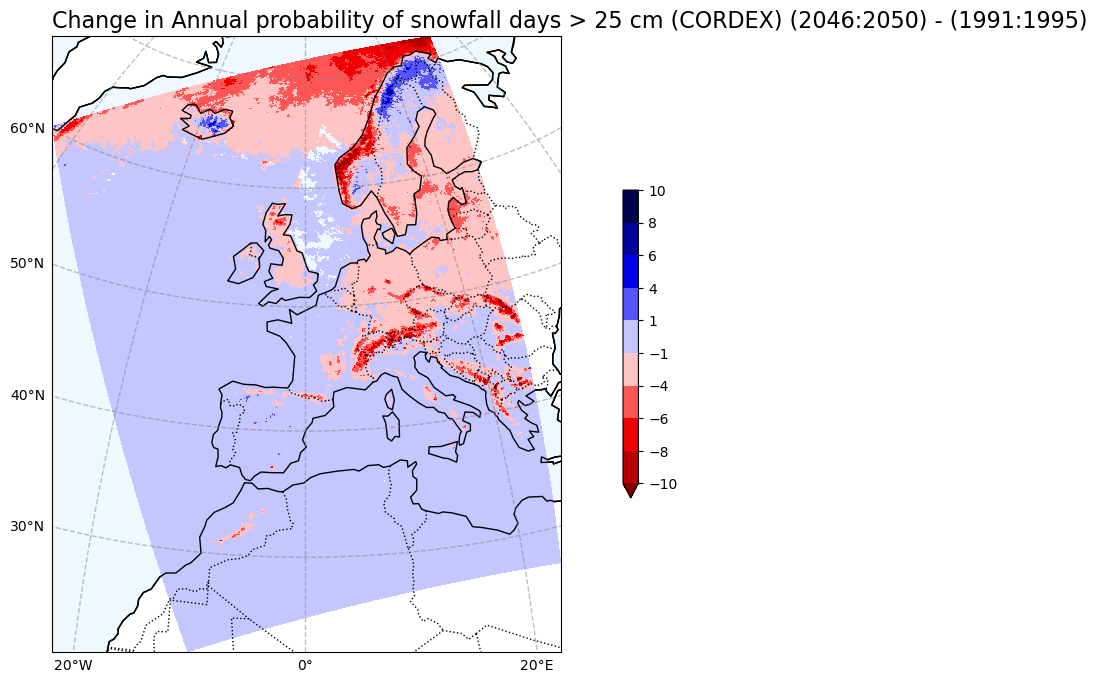

In [16]:
# Plot change in Annual probability of snowfall exceeding 25 cm
var1 = snow25Prob_annual_mean_change.snow_days
V1_p_levels = [-10, -8, -6, -4, -1, 1, 4, 6, 8, 10]
V1_cmap = 'seismic_r'

Tit1 = f'Change in Annual probability of snowfall days > 25 cm (CORDEX) ({RCP_start_year}:{RCP_end_year}) - ({Hist_start_year}:{Hist_end_year})'

V1_cb_tit = ' '
fileout = os.path.join(plot_dir, f'Chan_Ann_prob_snow_days_25_CORDEX_{gcm_model_Name}_{rcm_model_Name}_{RCP_experiment_in1}_{ensemble_member_in}_{RCP_start_year}_{RCP_end_year}.png')


plot_map_CORDEX(var1, V1_p_levels, V1_cmap, Tit1, V1_cb_tit,fileout)

### Exposure - Population data

In this illustration, we are using population data sourced from the JRC data portal, specifically the Global Human Settlement Layer [Global Human Settlement Layer GHSL](https://ghsl.jrc.ec.europa.eu/download.php?ds=pop), with 30 arcsec resolution global datasets. After downloading and extracting the data, Pooch will list the contents within the data directory. 

In [ ]:
url = 'https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GLOBE_R2023A/GHS_POP_E2015_GLOBE_R2023A_4326_30ss/V1-0/GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.zip'
pop_files = pooch.retrieve(
    url=url,
    known_hash=None,
    path=data_dir,
    processor=pooch.Unzip(extract_dir='')
)

The zip file contains data, as well as metadata and the documentation in the pdf file.

## Explore the data

### Population data

Population data is in file with filename: **GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.tif**

We can use rioxarray to load this file and explore the projections of the dataset.

In [19]:
filename_population = f'{data_dir}/GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.tif'

population = rxr.open_rasterio(filename_population)

population = population.rename({'x': 'longitude', 'y': 'latitude'})
population.rio.crs

CRS.from_epsg(4326)

Note that now, we have a directory **snow_workflow/data** where all the zip files and unzipped files are stored.

## Process the data

###  Population data

In this workflow, we want to overlay the population data on snowfall and blizzard indicators to better understand where these indicators affect densely populated areas. 

Take a closer look at the dimensions and coordinates of our two data objects. 
- Notice that the population data has **x** and **y** as spatial dimensions, while ERA5 has **latitude** and **longitude**. 
- Both datasets are in the same projection: **WSG84/epsg 4326**. 
- However, the resolutions of the datasets are different. 

To be able to plot these two datasets together, we must have them at the same resolution and zoomed in to the same area.

To regrid the data, we utilize the xESMF library, a Universal Regridder for Geospatial Data, to regrid the population data to match the ERA5 resolution. Prior to regridding, the population data is cropped specifically for the European region.

In [ ]:
Europe_population = population.sel(latitude=slice(80.0,20.0), longitude=slice(-10.0,45.0))
snow6Prob_annual_mean_ERA.rio.write_crs(4326, inplace=True)
snow6Prob_annual_mean_ERA.rio.crs

In [ ]:
# Building the regridder can take a while
regridder = xe.Regridder(Europe_population, snow6Prob_annual_mean_ERA, 'bilinear', periodic=True)

Europe_population_025deg = regridder(Europe_population)

# Alternatively, a much faster, but low-quality interpolation can be carried out with xarray:
#Europe_population_025deg = Europe_population.interp({
#    'latitude': snow6Prob_annual_mean_ERA["latitude"],
#    'longitude': snow6Prob_annual_mean_ERA["longitude"]
#})

del Europe_population_025deg['band']
del Europe_population_025deg['spatial_ref']

Europe_population_025deg.to_netcdf(path=os.path.join(data_dir, "Europe_population_25deg.nc"))


In [ ]:
# Explore the Population Density
var1 = np.squeeze(Europe_population_025deg)
V1_p_levels =  [1, 10, 30, 60, 100, 500, 1000]
V1_cmap = "hot_r"
Tit1 = 'Population Density'
V1_cb_tit = ' '
fileout = os.path.join(plot_dir, 'Population_Density.png')

plot_map_ERA5(var1, V1_p_levels, V1_cmap, Tit1, V1_cb_tit, fileout)

## Plot the results
### Select the area of interest
We are currently selecting the Alpine region because pollution density is higher in this area, and there is also a greater probability of heavy snow and blizzards, using the specified latitude and longitude extents, which can be modified as needed.


In [ ]:
xmin=4  # Min Longitude
xmax=15 # Max Longitude

ymin=42 # Min Latitude
ymax=50 # Max Latitude

SelArea_population  = Europe_population_025deg.sel(latitude=slice(ymax,ymin), longitude=slice(xmin,xmax))

SelArea_6cm_ind     = snow6Prob_annual_mean_ERA.sel(latitude=slice(ymax,ymin), longitude=slice(xmin,xmax))
SelArea_25cm_ind    = snow25Prob_annual_mean_ERA.sel(latitude=slice(ymax,ymin), longitude=slice(xmin,xmax))
SelArea_blizard_ind = BdayCount_anaProb_mean_ERA.sel(latitude=slice(ymax,ymin), longitude=slice(xmin,xmax))

### To explore the exposure and vulnerability of the population, plot them together

We are exclusively plotting snow indices in regions where the population density exceeds 1/km.

#### Plot population with Historical snow indices

In [ ]:
# Create a mask for snow data where pollution density is below 1
SelArea_6cm_ind_masked = SelArea_6cm_ind.snow_days.where(SelArea_population >= 1)
SelArea_25cm_ind_masked = SelArea_25cm_ind.snow_days.where(SelArea_population >= 1)
SelArea_blizard_ind_masked = SelArea_blizard_ind.blizzard_days.where(SelArea_population >= 1)

population_masked_Blizard = SelArea_population.where(SelArea_blizard_ind.blizzard_days > 0)

min_lon = xmin
max_lon = xmax
min_lat = ymin
max_lat = ymax

SelArea_population = SelArea_population.rename({'longitude': 'lon','latitude': 'lat'})

var1 = np.squeeze(SelArea_6cm_ind_masked)
var2 = np.squeeze(SelArea_population)

V1_p_levels = [0, 1, 5, 10, 30, 40]
V2_p_levels =  [1, 10, 30, 60, 100, 500, 1000]

V1_cmap = "GnBu"
V2_cmap = "hot_r"

Tit1 = 'Annual probability (%) of snowfall exceeding 6 cm'
V1_cb_tit = 'Population Density'
V2_cb_tit = 'Snow days'

fileout = os.path.join(plot_dir,'Population_Density_Annual_probability_snowfall_days_6cm.png'.format(areaname))

#plot_overlay_map(var1, var2, V1_p_levels, V2_p_levels, V1_cmap, V2_cmap, Tit1, V1_cb_tit, V2_cb_tit,fileout)
plot_overlay_map(var1, var2, V1_p_levels, V2_p_levels, V1_cmap, V2_cmap, Tit1, V1_cb_tit, V2_cb_tit,fileout,min_lon, max_lon, min_lat, max_lat)

In [ ]:
# Create a mask for snow data where pollution density is below 1
var1 = np.squeeze(SelArea_25cm_ind_masked)
var2 = np.squeeze(SelArea_population)

V1_p_levels = [0, 1, 5, 10, 30, 40]
V2_p_levels =  [1, 10, 30, 60, 100, 500, 1000]

V1_cmap = "GnBu"
V2_cmap = "hot_r"

Tit1 = 'Annual probability (%) of snowfall exceeding 25 cm'
V1_cb_tit = 'Population Density'
V2_cb_tit = 'Snow days'

fileout = os.path.join(plot_dir,'Population_Density_Annual_probability_snowfall_days_25cm.png'.format(areaname))

plot_overlay_map(var1, var2, V1_p_levels, V2_p_levels, V1_cmap, V2_cmap, Tit1, V1_cb_tit, V2_cb_tit,fileout,min_lon, max_lon, min_lat, max_lat)

In [ ]:
population_masked_Blizard = population_masked_Blizard.rename({'longitude': 'lon','latitude': 'lat'})

var1 = np.squeeze(SelArea_blizard_ind_masked)
var2 = np.squeeze(population_masked_Blizard)

V1_p_levels = [0, 1, 5, 10, 30, 40]
V2_p_levels =  [1, 10, 30, 60, 100, 500, 1000]

V1_cmap = "GnBu"
V2_cmap = "hot_r"

Tit1 = 'Change in annual probability of blizzard days'
V1_cb_tit = 'Population Density'
V2_cb_tit = ' '

fileout = os.path.join(plot_dir,'Population_Density_Annual_probability_blizzard.png'.format(areaname))

plot_overlay_map(var1, var2, V1_p_levels, V2_p_levels, V1_cmap, V2_cmap, Tit1, V1_cb_tit, V2_cb_tit,fileout,min_lon, max_lon, min_lat, max_lat)

#### Plot population with change in snow indices by mid-century

In [ ]:
var2 = np.squeeze(BdayCount_anaProb_mean_change.blizzard_days)
var1 = np.squeeze(SelArea_population)

V2_p_levels = [-1, -0.8, -0.6, -0.4, -0.2, 0.2, 0.4, 0.6, 0.8, 1]
V1_p_levels =  [1, 10, 30, 60, 100, 500, 1000]

V2_cmap = "PiYG"
V1_cmap = "hot_r"

Tit1 = 'Change in Annual probability (%) of snowfall exceeding 6 cm'
V2_cb_tit = 'Population Density'
V1_cb_tit = ' '

fileout = os.path.join(plot_dir,'Population_Density_Annual_probability_snowfall_days_6cm.png'.format(areaname))

plot_overlay_map(var1, var2, V1_p_levels, V2_p_levels, V1_cmap, V2_cmap, Tit1, V1_cb_tit, V2_cb_tit,fileout,min_lon, max_lon, min_lat, max_lat)

In [ ]:
var2 = np.squeeze(snow6Prob_annual_mean_change.snow_days)
var1 = np.squeeze(SelArea_population)

V2_p_levels = [-10, -8, -6, -4, -2, 2, 4, 6, 8, 10]
V1_p_levels =  [1, 10, 30, 60, 100, 500, 1000]

V2_cmap = "PiYG"
V1_cmap = "hot_r"

Tit1 = 'Change in Annual probability (%) of snowfall exceeding 6 cm'
V2_cb_tit = 'Population Density'
V1_cb_tit = ' '

fileout = os.path.join(plot_dir,'Population_Density_Annual_probability_snowfall_days_6cm.png'.format(areaname))

plot_overlay_map(var1, var2, V1_p_levels, V2_p_levels, V1_cmap, V2_cmap, Tit1, V1_cb_tit, V2_cb_tit,fileout,min_lon, max_lon, min_lat, max_lat)

In [ ]:
var2 = np.squeeze(snow25Prob_annual_mean_change.snow_days)
var1 = np.squeeze(SelArea_population)

V2_p_levels = [-10, -8, -6, -4, -2, 2, 4, 6, 8, 10]
V1_p_levels =  [1, 10, 30, 60, 100, 500, 1000]

V2_cmap = "PiYG"
V1_cmap = "hot_r"

Tit1 = 'Change in Annual probability (%) of snowfall exceeding 25 cm'
V2_cb_tit = 'Population Density'
V1_cb_tit = ' '

fileout = os.path.join(plot_dir,'Population_Density_Annual_probability_snowfall_days_25cm.png'.format(areaname))

plot_overlay_map(var1, var2, V1_p_levels, V2_p_levels, V1_cmap, V2_cmap, Tit1, V1_cb_tit, V2_cb_tit,fileout,min_lon, max_lon, min_lat, max_lat)

## Conclusions
In this workflow, we've illustrated the process of exploring, processing, and visualizing data necessary for analyzing the influence of heavy snowfall and blizzard day indices on population density. These indices are presented as annual probabilities of occurrence, reflecting the likelihood of a particular event happening over several years. In the present climate, communities in the northern Alpine region face heightened vulnerability to heavy snowfall and blizzards. However, under the RCP2.5 scenario by mid-century, we observe a significant reduction in the severity of these hazards across the region compared to the current climate. 

## Contributors

- Suraj Polade, Finnish Meteorological Institute
- Andrea Vajda, Finnish Meteorological Institute